## Importando Bibliotecas

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

## Definindo Hiperparâmetros

In [2]:
args = {
    'batch_size': 100,
    'num_workers': 16,
    'epoch_num': 300,
    'lr': 0.006,
    'weight_decay': 3e-05,
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

args

{'batch_size': 100,
 'num_workers': 16,
 'epoch_num': 300,
 'lr': 0.006,
 'weight_decay': 3e-05,
 'device': device(type='cpu')}

## Lendo arquivo com os dados

In [3]:
# df = pd.read_csv('dados/carros_sp_sem_outliers.csv')
# df = pd.read_csv('dados/carros_sem_outliers.csv')
df = pd.read_csv('dados/ka_sp.csv')
df = df.drop(['modelo', 'marca', 'combustivel', 'cambio', 'potenciamotor', 'blindado'], axis=1)
# df = pd.read_csv('dados/hb20_sp.csv')
# df = pd.read_csv('ford_sp.csv')
df.head()

,direcao,cor,ano,quilometragem,valor
0,1,0,2017,76000,39990.0
1,1,9,2018,99999,39990.0
2,1,0,2015,36000,37490.0
3,2,0,2017,64000,37500.0
4,2,0,2017,87000,33000.0


In [4]:
print(f'Quantidade de registros e de colunas: {df.shape}')

Quantidade de registros e de colunas: (537, 5)


## Separando em conjunto de teste e de treino

In [5]:
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))

df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

df_train.to_csv('car_train.csv', index=False)
df_test.to_csv('car_test.csv', index=False)

print(df_train.shape, df_test.shape)

(429, 5) (108, 5)


## Classe Carro

In [6]:
class Car(Dataset):
    def __init__(self, csv_path, columns):
        self.dados = pd.read_csv(csv_path).to_numpy()        
        self.columns = columns

    def __getitem__(self, idx):        
        sample = self.dados[idx][:self.columns]
        label = self.dados[idx][-1:]

        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))

        return sample, label

    def __len__(self):
        return len(self.dados)


## Carregando dados de treino e de teste

In [7]:
train_set = Car('car_train.csv', df.shape[1]-1)
test_set = Car('car_test.csv', df.shape[1]-1)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)

test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

## Criando MLP

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(MLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, out_size),
            nn.ReLU(),
        )

    def forward(self, X):

        hidden = self.features(X)
        output = self.classifier(hidden)

        return output

In [9]:
input_size = train_set[0][0].shape[0]
hidden_size = int((train_set[0][0].shape[0] + 1) / 2)
out_size = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])

net

MLP(
  (features): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): ReLU()
  )
)

## Definindo loss e otimizador

In [10]:
criterion = nn.L1Loss().to(args['device'])
diferenca = nn.L1Loss().to(args['device'])

#optimizer = optim.Adam(net.parameters(), 
#                       lr=args['lr'], 
#                       weight_decay=args['weight_decay'])

optimizer = optim.Adam(net.parameters())

dif_train, dif_test = [], []

## Treino e Validação

In [11]:
def train(train_loader, net, epoch):
    # Training mode
    net.train()
    start = time.time()
    epoch_loss  = []    
    epoch_dif = []
    
    for batch in train_loader:
        dado, rotulo = batch
    
        # Cast do dado na GPU
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])

        optimizer.zero_grad()
        
        # Forward
        ypred = net(dado)
        loss = criterion(ypred, rotulo)
        
        dif = diferenca(ypred, rotulo)
        dif_train.append(dif.cpu().data)
        
        epoch_dif.append(dif.cpu().data)
        epoch_loss.append(loss.cpu().data)

        # Backpropagation
        loss.backward()
        optimizer.step()
   
    epoch_loss = np.asarray(epoch_loss)
    epoch_dif = np.asarray(epoch_dif)
  
    end = time.time()
    print('#################### Train ####################')
    print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_dif.mean(), end-start))

    return epoch_loss.mean()

In [12]:
def validate(test_loader, net, epoch):
    # Evaluation mode
    net.eval()
    start = time.time()
    epoch_loss  = []
    epoch_dif = []

    with torch.no_grad(): 
        for batch in test_loader:
            dado, rotulo = batch

            # Cast do dado na GPU
            dado = dado.to(args['device'])
            rotulo = rotulo.to(args['device'])
            
            optimizer.zero_grad()
            
            # Forward
            ypred = net(dado)
            loss = criterion(ypred, rotulo)
            
            dif = diferenca(ypred, rotulo)
            dif_test.append(dif.cpu().data)
            
            epoch_dif.append(dif.cpu().data)
            epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)
    epoch_dif = np.asarray(epoch_dif)

    end = time.time()
    print('********** Validate **********')
    print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_dif.mean(), end-start))

    return epoch_loss.mean()

## Treinamento

In [13]:
train_losses, test_losses = [], []
start = time.time()

for epoch in range(args['epoch_num']):
    # Train
    train_losses.append(train(train_loader, net, epoch))

    # Validate
    test_losses.append(validate(test_loader, net, epoch))

end = time.time()
print(end-start)

#################### Train ####################
Epoch 0, Loss: 39285.0703 +/- 39285.0703, Time: 0.21
********** Validate **********
Epoch 0, Loss: 39690.7812 +/- 39690.7812, Time: 0.22

#################### Train ####################
Epoch 1, Loss: 39405.3047 +/- 39405.3047, Time: 0.24
********** Validate **********
Epoch 1, Loss: 39624.6016 +/- 39624.6016, Time: 0.21

#################### Train ####################
Epoch 2, Loss: 39191.4492 +/- 39191.4492, Time: 0.25
********** Validate **********
Epoch 2, Loss: 39554.2344 +/- 39554.2344, Time: 0.21

#################### Train ####################
Epoch 3, Loss: 39144.4883 +/- 39144.4883, Time: 0.24
********** Validate **********
Epoch 3, Loss: 39479.0508 +/- 39479.0508, Time: 0.29

#################### Train ####################
Epoch 4, Loss: 39429.0977 +/- 39429.0977, Time: 0.24
********** Validate **********
Epoch 4, Loss: 39398.5938 +/- 39398.5938, Time: 0.22

#################### Train ####################
Epoch 5, Loss: 39076.1

## Grafico de Convergência

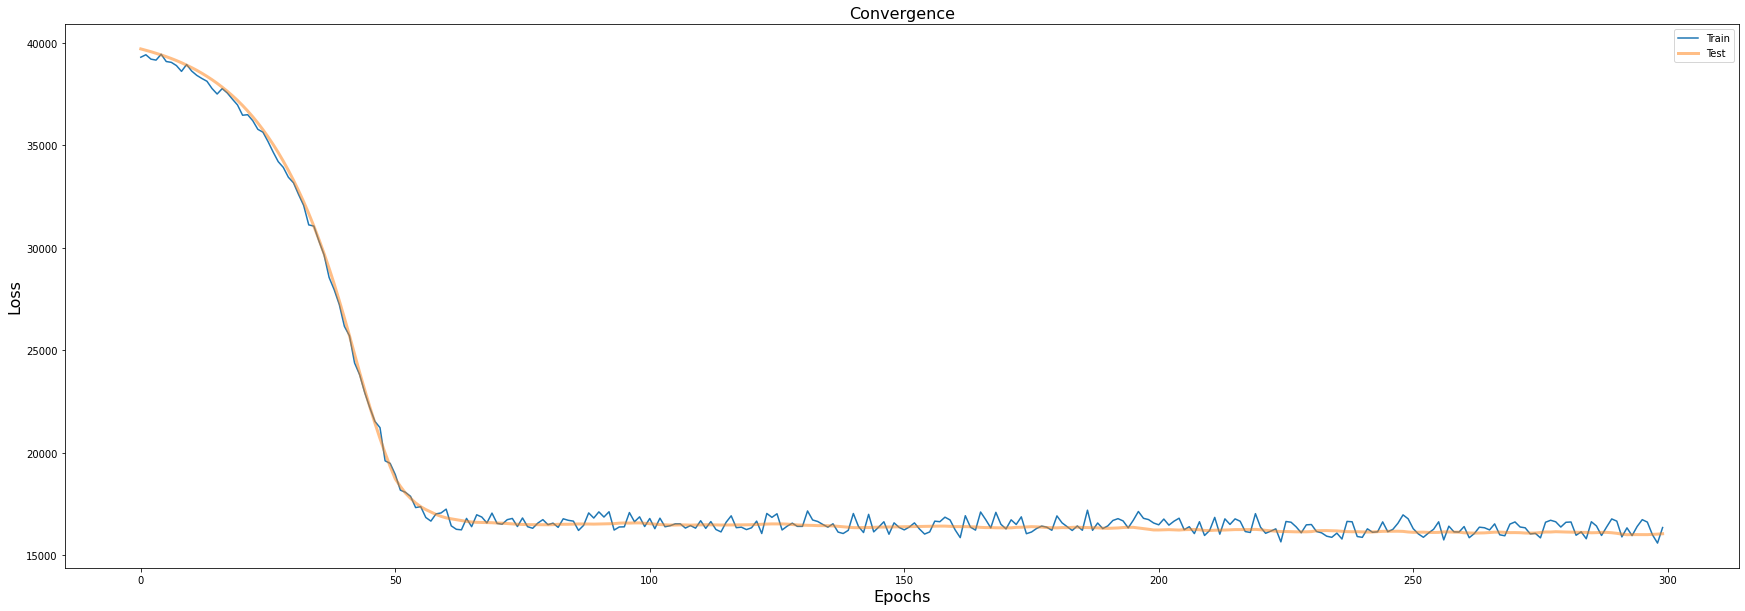

In [14]:
plt.figure(figsize=(30, 10))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

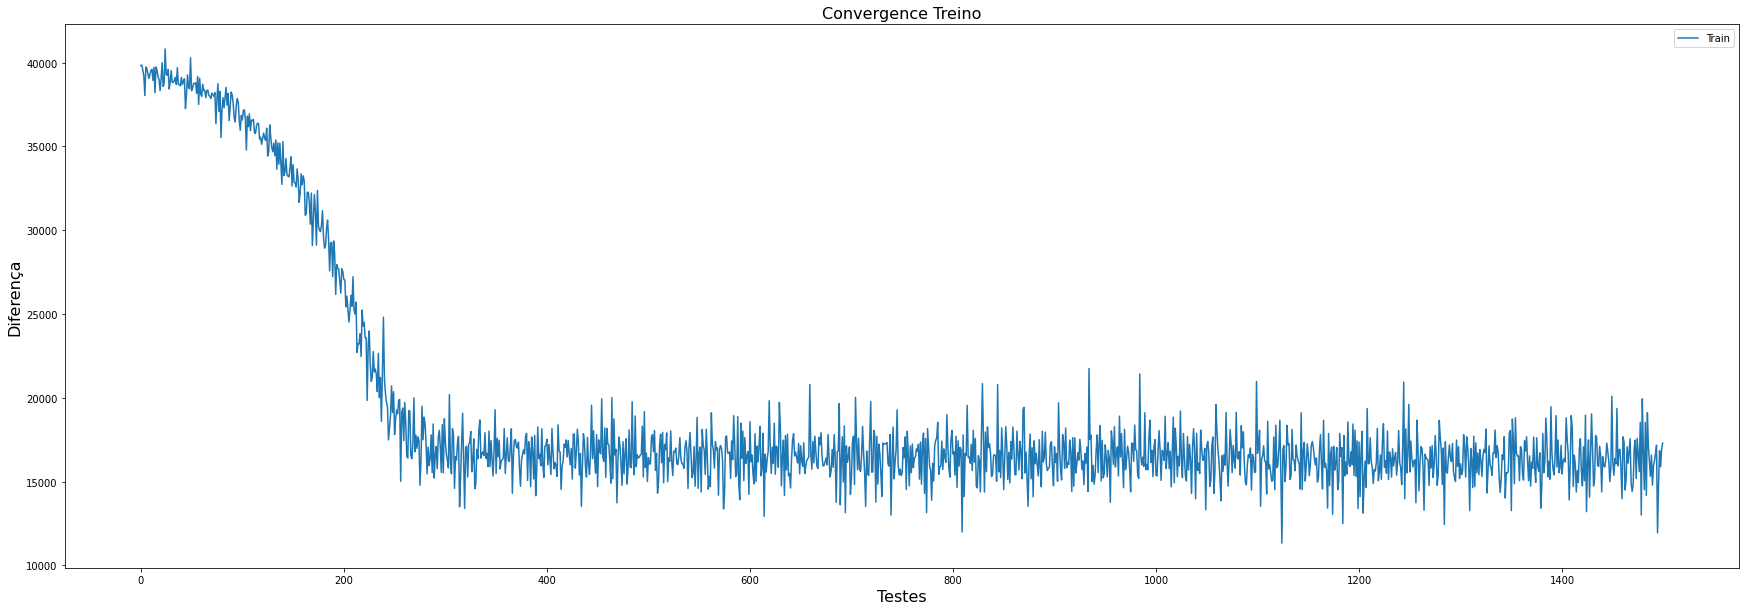

In [15]:
plt.figure(figsize=(30, 10))
plt.plot(dif_train, label='Train')
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Treino', fontsize=16)
plt.legend()
plt.show()

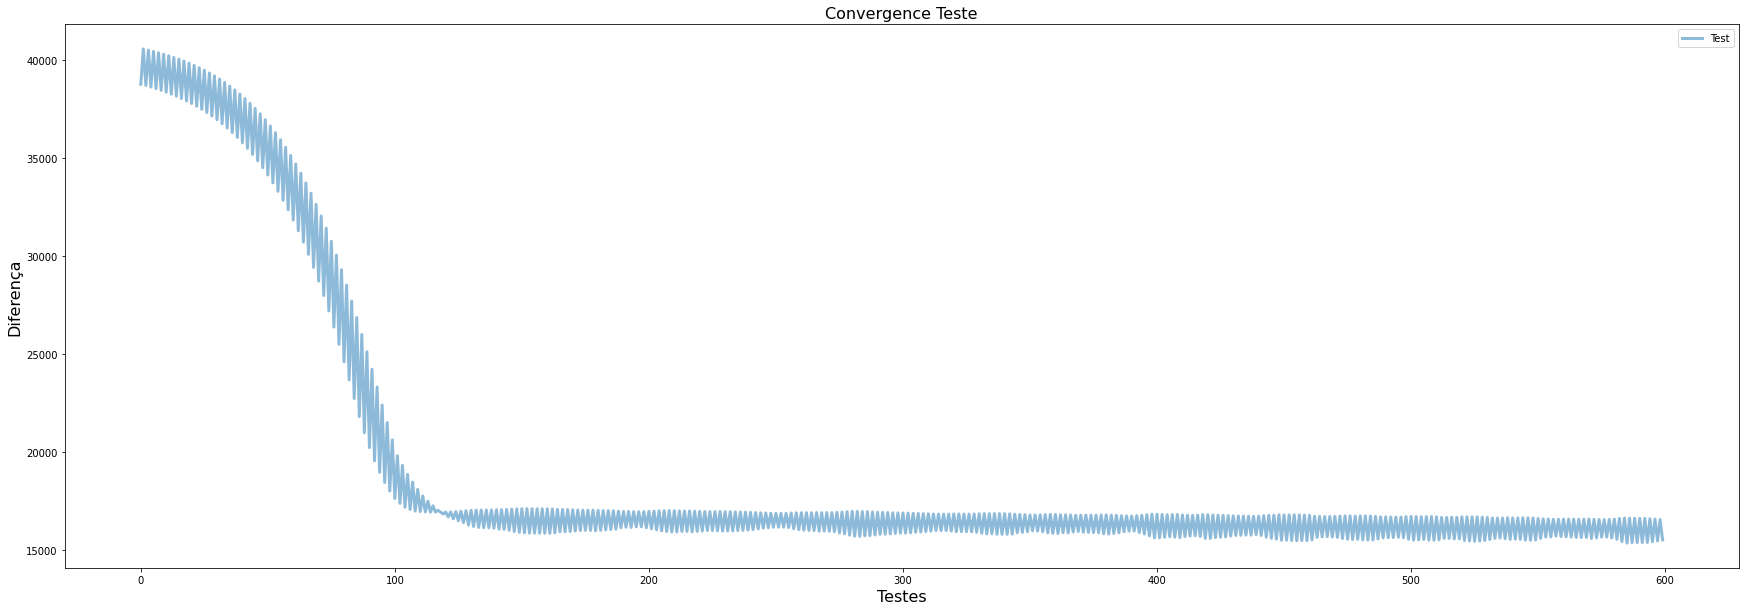

In [16]:
plt.figure(figsize=(30, 10))
plt.plot(dif_test, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Teste', fontsize=16)
plt.legend()
plt.show()

## Melhores Loss

In [17]:
train_losses = np.asarray(train_losses)
test_losses = np.asarray(test_losses)
dif_train = np.asarray(dif_train)
dif_test = np.asarray(dif_test)

print(f'Menor Valor de Loss por Época de Treino: {min(train_losses)}')
print(f'Maior Valor de Loss por Época de Treino: {max(train_losses)}')
print(f'Valor Médio de Loss por Época de Treino: {train_losses.mean()}')

print()

print(f'Menor Valor de Loss por Época de Teste: {min(test_losses)}')
print(f'Maior Valor de Loss por Época de Teste: {max(test_losses)}')
print(f'Valor Médio de Loss por Época de Teste: {test_losses.mean()}')

print()

print(f'Menor Valor de Loss por Registro de Treino: {min(dif_train)}')
print(f'Maior Valor de Loss por Registro de Treino: {max(dif_train)}')
print(f'Valor Médio de Loss por Registro de Treino: {dif_train.mean()}')

print()

print(f'Menor Valor de Loss por Registro de Teste: {min(dif_test)}')
print(f'Maior Valor de Loss por Registro de Teste: {max(dif_test)}')
print(f'Valor Médio de Loss por Registro de Teste: {dif_test.mean()}')

Menor Valor de Loss por Época de Treino: 15593.837890625
Maior Valor de Loss por Época de Treino: 39429.09765625
Valor Médio de Loss por Época de Treino: 19247.5625

Menor Valor de Loss por Época de Teste: 16002.3662109375
Maior Valor de Loss por Época de Teste: 39690.78125
Valor Médio de Loss por Época de Teste: 19187.6171875

Menor Valor de Loss por Registro de Treino: 11330.0537109375
Maior Valor de Loss por Registro de Treino: 40811.54296875
Valor Médio de Loss por Registro de Treino: 19247.5625

Menor Valor de Loss por Registro de Teste: 15362.466796875
Maior Valor de Loss por Registro de Teste: 40590.96484375
Valor Médio de Loss por Registro de Teste: 19187.6171875


In [18]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    if var_name == "param_groups":
        print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]


In [19]:
torch.save(net, 'modelo_classificao_se_onix')

In [20]:
# testeModelo = torch.load('modelo_classificao-3')
# testeModelo.eval()

In [21]:
#lista = [1425,45,4,2,2,0,2019, 61000, 1.6,0]
#tensor = torch.FloatTensor(lista)
#valor = testeModelo.forward(tensor).item()
#valor

In [22]:
# vw = pd.read_csv('ka.csv')
#vw.drop(['combustivel', 'blindado', 'cor', 'potenciamotor'], axis=1, inplace=True)
# vw.head()

In [23]:
# dif = []
# real = []
# previsto = []
# for i in range(vw.shape[0]):
#     tensor = torch.FloatTensor(np.asarray(vw.iloc[i, :-1]))    
#     valor = testeModelo.forward(tensor).item()
#     dif.append(float(round(valor-np.asarray(vw.iloc[i,-1]), 2)))
#     print(f"{np.asarray(vw.iloc[i,-1])} -> {round(valor, 2)} => {round(valor-np.asarray(vw.iloc[i,-1]), 2)}")    
#     real.append(vw.iloc[i,-1])
#     previsto.append(valor)

In [24]:
# dif = np.asarray(dif)

In [25]:
# dif

In [26]:
# print(min(dif), max(dif), dif.mean())

In [27]:
# print(min(dif[dif > 0]), max(dif[dif > 0]), dif[dif > 0].mean())

In [28]:
# dif[dif > 0].std()

In [29]:
# plt.figure(figsize=(20, 9))
# plt.plot(real, label='Real', linewidth=3, alpha=0.5)
# plt.plot(previsto, label='Previsto')
# plt.xlabel('Testes', fontsize=16)
# plt.ylabel('Diferença', fontsize=16)
# plt.title('Convergence Teste', fontsize=16)
# plt.legend()
# plt.show()

In [30]:
# plt.figure(figsize=(20, 9))
# plt.plot(real[100:200], label='Real', linewidth=3, alpha=0.5)
# plt.plot(previsto[100:200], label='Previsto')
# plt.xlabel('Testes', fontsize=16)
# plt.ylabel('Diferença', fontsize=16)
# plt.title('Convergence Teste', fontsize=16)
# plt.legend()
# plt.show()